Семинар 2. Определение языка (language detection)
--------------------

In [0]:
!pip install wikipedia

In [0]:
import wikipedia
import numpy as np
import os
import json
import requests, re
from time import sleep

посмотрим какие языки есть в википедии и какие коды им соответствуют:

In [0]:
code2lang = wikipedia.languages()

In [0]:
[(lang, name) for lang, name in list(code2lang.items()) if re.search('[а-яё]', name)]

[('ab', 'Аҧсшәа'),
 ('ady', 'адыгабзэ'),
 ('ady-cyrl', 'адыгабзэ'),
 ('av', 'авар'),
 ('ba', 'башҡортса'),
 ('be', 'беларуская'),
 ('be-tarask', 'беларуская (тарашкевіца)\u200e'),
 ('be-x-old', 'беларуская (тарашкевіца)\u200e'),
 ('bg', 'български'),
 ('bxr', 'буряад'),
 ('ce', 'нохчийн'),
 ('crh-cyrl', 'къырымтатарджа (Кирилл)\u200e'),
 ('cu', 'словѣньскъ / ⰔⰎⰑⰂⰡⰐⰠⰔⰍⰟ'),
 ('cv', 'Чӑвашла'),
 ('inh', 'ГӀалгӀай'),
 ('kbd', 'Адыгэбзэ'),
 ('kbd-cyrl', 'Адыгэбзэ'),
 ('kk', 'қазақша'),
 ('kk-cyrl', 'қазақша (кирил)\u200e'),
 ('kk-kz', 'қазақша (Қазақстан)\u200e'),
 ('koi', 'Перем Коми'),
 ('krc', 'къарачай-малкъар'),
 ('kum', 'къумукъ'),
 ('kv', 'коми'),
 ('ky', 'Кыргызча'),
 ('lbe', 'лакку'),
 ('lez', 'лезги'),
 ('mdf', 'мокшень'),
 ('mhr', 'олык марий'),
 ('mk', 'македонски'),
 ('mn', 'монгол'),
 ('mo', 'молдовеняскэ'),
 ('mrj', 'кырык мары'),
 ('myv', 'эрзянь'),
 ('os', 'Ирон'),
 ('ru', 'русский'),
 ('rue', 'русиньскый'),
 ('ruq-cyrl', 'Влахесте'),
 ('sah', 'саха тыла'),
 ('sh', 'srpskoh

выберем несколько языков с кириллическим алфавитом (судя по названию языка):

In [0]:
langs = ['be', 'bg', 'ky', 'lez' , 'mhr', 'mn', 'mk', 'mo', 'ru', 'sty', 'uk', 'en']

In [0]:
# расшифровка 
[(lang, code2lang[lang]) for lang  in langs]

[('be', 'беларуская'),
 ('bg', 'български'),
 ('ky', 'Кыргызча'),
 ('lez', 'лезги'),
 ('mhr', 'олык марий'),
 ('mn', 'монгол'),
 ('mk', 'македонски'),
 ('mo', 'молдовеняскэ'),
 ('ru', 'русский'),
 ('sty', 'cебертатар'),
 ('uk', 'українська'),
 ('en', 'English')]

Выбрать какие-то случайные статьи можно с помощью функции wikipedia.random(n) (n - число статей)

Скачивание занимает некоторое время и может выдавать всякие непредсказуемые ошибки, поэтому не забывайте про добавлять обработчик исключения в аналогичные функции.

In [0]:
# def get_texts_for_lang(lang, n=100): # функция для скачивания статей из википедии
#     wikipedia.set_lang(lang)
#     wiki_content = []
#     pages = wikipedia.random(n)
    
#     for page_name in pages:
#         try:
#             sleep(0.3)
#             page = wikipedia.page(page_name)
        
#         except Exception as e:
#             print('Skipping page {}'.format(page_name), e)
#             continue

#         wiki_content.append('{}\n{}'.format(page.title, page.content.replace('==', '')))

#     return wiki_content

In [0]:
# # скачиваем по 120 случайных статей для каждого языка
# wiki_texts = {}
# for lang in langs:
    
#     try:
#         wiki_texts[lang] = get_texts_for_lang(lang, 100)
#     except Exception as e:
#         print('ERROR ON - ', lang, e)
#         continue
#     print(lang, len(wiki_texts[lang]))

In [0]:
# # скачиваем по 120 случайных статей для каждого языка
# wiki_texts_test = {}
# for lang in langs:
    
#     try:
#         wiki_texts_test[lang] = get_texts_for_lang(lang, 15)
#     except Exception as e:
#         print('ERROR ON - ', lang, e)
#         continue
#     print(lang, len(wiki_texts_test[lang]))

Я сделал это заранее, чтобы вам не пришлось мучаться. Скачайте их тут - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/data/wiki_texts.json

In [0]:
# json.dump(wiki_texts, open('wiki_texts.json', 'w'))
# json.dump(wiki_texts_test, open('wiki_texts_test.json', 'w'))

In [0]:
wiki_texts = json.loads(open('wiki_texts.json', 'r', encoding='utf8').read())
wiki_texts_test = json.loads(open('wiki_texts_test.json', 'r', encoding='utf8').read())


In [0]:
list(wiki_texts.keys())

['be', 'bg', 'ky', 'lez', 'mhr', 'mn', 'mk', 'ru', 'uk', 'en']

In [0]:
list(wiki_texts_test.keys())

['be', 'bg', 'ky', 'lez', 'mhr', 'mn', 'mk', 'ru', 'uk', 'en']

In [0]:
langs = list(wiki_texts.keys())

## Как можно определить язык?

### 1 По набору букв

У каждого языка есть какой-то определенный набор символов, которые в нем используются. Даже между двумя очень близкими языками есть различия на уровне символовов. Попробуем определять язык по множеству символов.

In [0]:
from collections import defaultdict, Counter
from string import punctuation, digits
punctuation = set(punctuation + '«»—…“”\n\t' + digits)

Создадим множества символов, представляющих язык, по скачанным текстам.

Нужно создать словарь, в котром каждому ключу соотвествует множество. Удобно это сделать с помощью defaultdict. Он устроен примерно как обычный питоновский словарь, но ему можно задать значение нового ключа по умолчанию. 
Синтаксис такой:

***d = defaultdict(callable)***


callable - это такой питоновский объект, который можно вызвать (добавив скобки) и он что-то вернет. Соответственно, для каждого нового элемента будет вызываться этот callable и присваивать элементу значение, которое он вернет. 
Например, **set** - это callable, который при вызове ***set()*** вернет пустое множество. То есть, каждому новому элементу будет соответствовать пустое множество. Аналогично будет с int, dict, tuple, str, float.

Если нужно сделать какой-то особое значение по умолчанию, можно написать отдельную функцию или сделать это через lambda. Например, lamda: {'хороших':0, 'плохих':0} сделает так, чтобы каждому элементу по умолчанию ставился словарь с двумя ключами (хороших, плохих) и нулевыми значениями.

Когда используете defaultdict, помните, d['random_stuff'] не выдаст никакой ошибки и у вас в словаре появится этот объект.



### Пример того, как defaultdict упрощает код:    

In [0]:
# создадим словарь, где ключ - символы, а значения все слова в которых он встречается
dictionary = {}
tokens = ['i', 'have', 'too', 'many', 'deadlines']

for token in tokens:
    for char in token:
        if char in dictionary:
            dictionary[char].add(token)
        else:
            dictionary[char] = {token}

In [0]:
dictionary

{'i': {'deadlines', 'i'},
 'h': {'have'},
 'a': {'deadlines', 'have', 'many'},
 'v': {'have'},
 'e': {'deadlines', 'have'},
 't': {'too'},
 'o': {'too'},
 'm': {'many'},
 'n': {'deadlines', 'many'},
 'y': {'many'},
 'd': {'deadlines'},
 'l': {'deadlines'},
 's': {'deadlines'}}

In [0]:
# создадим словарь, где ключ - символы, а значения все слова в которых он встречается
dictionary = defaultdict(set)
tokens = ['i', 'have', 'too', 'many', 'deadlines']

for token in tokens:
    for char in token:
        dictionary[char].add(token)

In [0]:
dictionary

defaultdict(set,
            {'i': {'deadlines', 'i'},
             'h': {'have'},
             'a': {'deadlines', 'have', 'many'},
             'v': {'have'},
             'e': {'deadlines', 'have'},
             't': {'too'},
             'o': {'too'},
             'm': {'many'},
             'n': {'deadlines', 'many'},
             'y': {'many'},
             'd': {'deadlines'},
             'l': {'deadlines'},
             's': {'deadlines'}})

In [0]:
lang2chars = defaultdict(set)

# операция "-" для множества означает разность, т.е. "все елементы x, которых нет в y"
# удобно таким образом отфильтровать все знаки пунктуации
for lang in langs:
    for text in wiki_texts[lang]:
        chars = [ch for ch in text.lower() if ch not in punctuation]
        top_chars = [char for char, _ in Counter(chars).most_common(30)]
        
        lang2chars[lang].update(top_chars)

In [0]:
lang2chars.keys()

dict_keys(['be', 'bg', 'ky', 'lez', 'mhr', 'mn', 'mk', 'ru', 'uk', 'en'])

In [0]:
# посмотрим на какой-нибудь язык
len(lang2chars['ru'])

68

Теперь сделаем функцию, которая предсказывает язык на основе пересечения множеств символов.

In [0]:
# оператор & означает пересечение

def predict_language(text, lang2char):
    text_chars = set(text.lower())
    lang2sim = {}
    for lang in lang2char:
        intersect = len((text_chars - punctuation) & lang2char[lang])
        lang2sim[lang] = intersect
    
#     return lang2sim.items()
    return max(lang2sim, key=lang2sim.get)

In [0]:
predict_language('какой это язык', lang2chars)

'be'

In [0]:
# отклассифицурем все тексты, которые у нас есть
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
true_labels = []
predicted_labels = []

for lang in langs:
    for text in wiki_texts_test[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language(text, lang2chars))

In [0]:
print(classification_report(true_labels, predicted_labels, ))

              precision    recall  f1-score   support

          be       0.69      0.92      0.79        12
          bg       0.75      0.86      0.80        14
          en       1.00      0.87      0.93        15
          ky       0.56      0.93      0.70        15
         lez       0.68      0.87      0.76        15
         mhr       0.92      0.86      0.89        14
          mk       1.00      1.00      1.00        14
          mn       0.29      0.13      0.18        15
          ru       0.86      0.40      0.55        15
          uk       1.00      0.92      0.96        12

    accuracy                           0.77       141
   macro avg       0.77      0.77      0.76       141
weighted avg       0.77      0.77      0.75       141



In [0]:
labels = list(set(true_labels))

In [0]:
print(confusion_matrix(true_labels, predicted_labels, labels = labels))

[[13  1  0  0  1  0  0  0  0  0]
 [ 1 12  0  0  0  0  0  0  1  0]
 [ 0  2 13  0  0  0  0  0  0  0]
 [ 1  0  0 12  1  0  0  0  0  0]
 [ 0  1  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0]
 [ 4  0  0  1  1  0  6  0  3  0]
 [ 0  0  0  0  0  0  1 11  0  0]
 [ 0  0  0  0  2  0  0  0  2 11]
 [ 0  0  0  0  0  0  0  0  1 14]]


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

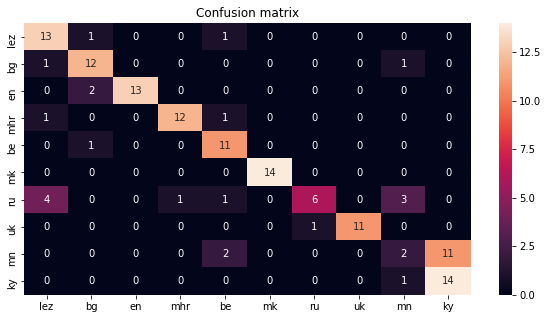

In [0]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), 
            annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

### 2 По набору буквенных нграм

Буквенных нграм слишком много для одного множества, поэтому нужно как-то выделить топ-N.

Для частотностей есть Counter. По сути это ***defaultdict(int)*** только немного удобнее.
Можно создавать Counter из любого iterable объекта, складывать два каунтера (одинаковые знаения сложатся, а новые просто добавятся, удобно сортировать элементы по частотности методов Counter.most_common(topn)

In [0]:
from collections import Counter

In [0]:
# функция для создания нграммов из строки
def n_grams(text, n=2):
    # удаляем пунктуацию
    text_wo_punct = ''.join([ch for ch in text if ch not in punctuation])
    # создаем нграммы, выкидываем пробелы на концах нграммов
    ngrams = [text_wo_punct[i:i+n].strip(' ') for i in range(0, len(text_wo_punct)+1-n)]
    
    return set(ngrams)

In [0]:
# посчитаем частотность нграммов
lang2char_ngrams_freqs = defaultdict(Counter)

for lang in langs:
    for text in wiki_texts[lang]:
        char_ngrams = n_grams(text.lower(), 3)
        lang2char_ngrams_freqs[lang].update(filter(bool, char_ngrams))

# сделаем множества с топ 300 нграммамим

lang2char_ngrams = {}
for lang in lang2char_ngrams_freqs:
    topn = [word for word, freq in lang2char_ngrams_freqs[lang].most_common(300)]
    lang2char_ngrams[lang] = set(topn)


In [0]:
list(lang2char_ngrams['ru'])[:15]

['ате',
 'а т',
 'ост',
 'ран',
 'нос',
 'а п',
 'т',
 'лов',
 'или',
 'ло',
 'я с',
 'да',
 'им',
 'а с',
 'чан']

In [0]:
def predict_language(text, lang2char):
    text_ngrams = n_grams(text.lower(), 3)
    
    lang2sim = {}
    
    for lang in lang2char:
        intersect = len(text_ngrams & lang2char[lang])
        lang2sim[lang] = intersect
    
    return max(lang2sim, key=lang2sim.get)
#     return lang2sim

In [0]:
predict_language('What kinda language is that', lang2char_ngrams)

'en'

In [0]:
predict_language('что это за язык', lang2char_ngrams)

'uk'

In [0]:
true_labels = []
predicted_labels = []

for lang in langs:
    for text in wiki_texts_test[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language(text, lang2char_ngrams))

In [0]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

          be       1.00      1.00      1.00        12
          bg       1.00      1.00      1.00        14
          en       1.00      1.00      1.00        15
          ky       0.94      1.00      0.97        15
         lez       1.00      1.00      1.00        15
         mhr       1.00      0.93      0.96        14
          mk       1.00      1.00      1.00        14
          mn       1.00      1.00      1.00        15
          ru       1.00      1.00      1.00        15
          uk       1.00      1.00      1.00        12

    accuracy                           0.99       141
   macro avg       0.99      0.99      0.99       141
weighted avg       0.99      0.99      0.99       141



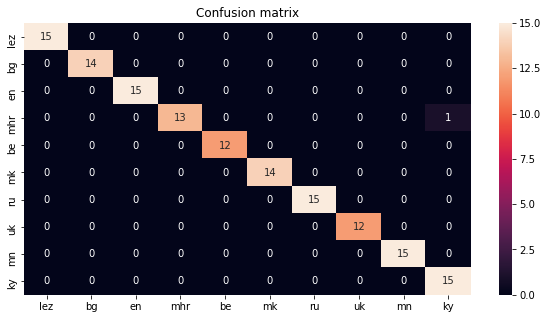

In [0]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), 
            annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

Местами есть проблемы, но в основном все отлично

Напишем функцию, которая будет принимать текст производной длинны и языка (из тех, что у нас уже есть) и выводить основной язык и слова, которые не соответствуют это языку текста.

То есть по запросу "шо это за язык?
должно получится "Основной язык  - ru, не соотвествующее слова: шо"

In [0]:
punct = ''.join(punctuation)

def predict_foreign_words(text):
    lang = predict_language(text, lang2char_ngrams)
    
    words = [word.strip(punct) for word in text.lower().split()]
    foreign_words = []
    for word in words:
        lang_word = predict_language(word, lang2char_ngrams)
        if lang_word != lang:
            foreign_words.append(word)
    

    
    return lang, foreign_words

Вот так это примерно работает (у меня получается плохо)

In [0]:
test_text_1 = 'Младший лейтенант мальчик молодой everybody хотят to dance с тобой'
print(predict_foreign_words(test_text_1))

('mn', ['младший', 'лейтенант', 'мальчик', 'everybody', 'to', 'dance', 'с', 'тобой'])


In [0]:
test_text_2 = 'Тут хто-нэбудь розмовляйе по-русски?'
print(predict_foreign_words(test_text_2 ))

('bg', ['тут', 'хто-нэбудь', 'розмовляйе', 'по-русски'])


In [0]:
test_text_3 = 'Як дабрацца российского пасольства??'
print(predict_foreign_words(test_text_3 ))

('be', ['российского'])


In [0]:
test_text_4 = 'Ончыч Куженер кундемысе «Ӱжара» газета редакторлан тыршен,\
вара райсовет исполкомын вуйлатышыжлан,\
КПСС райкомын икымше секретарьжылан ыштен.'
print(predict_foreign_words(test_text_4))

('ky', ['ончыч', 'куженер', 'кундемысе', 'ӱжара', 'газета', 'тыршен,вара', 'райсовет', 'исполкомын', 'райкомын', 'икымше', 'ыштен'])


## Добавим частотности

До этого мы учитывали только само наличие нграмм или символов, но очевидно, что важно ещё и распределние частот по этим нграммам. В родственных языках символы могут быть почти одинаковые, но вот частота употребления точно будет отличаться.

Попробуем представить каждый язык как распределение на символьных нграммах.

In [0]:
import numpy as np

In [0]:
# cоздадим общий словарь нграммов с частотностью
vocab = Counter()

for lang in langs:
    for text in wiki_texts[lang]:
        vocab.update(n_grams(text, 3))

# выберем топ-3000 нграммов и сохраним их в список
vocab = [word for word,_ in vocab.most_common(3000)]
#сделаем словарь нграм-индекс, индекс слова для удобства
id2ngram = {i:ngram for i, ngram in enumerate(vocab)}
ngram2id = {ngram:i for i, ngram in enumerate(vocab)}

Теперь нужно представить каждый язык, как вектор размером словаря.

Чтобы было понятнее вот пример со словами. Каждая строчка - текст, а в колонках слова. Число на пересечении показывает, сколько раз это слово встретилось в этом тексте.

![title](https://github.com/Yan-Weijia/CompLing/blob/master/%E8%AF%BE%E5%A0%82%E5%86%85%E5%AE%B9/191205language_detection/matrix_text.png?raw=1)

Создаем матрицу.

In [0]:
lang_matrix = np.zeros((len(langs), len(vocab)))

Заполняем матрицу значениями. Вместо простых нулей и единиц будет ставить колиство вхождений.

In [0]:
for i, lang in enumerate(langs):
    
    for text in wiki_texts[lang]:
        ngrams = n_grams(text.lower(), 3)
        
        for ngram in ngrams:
            if ngram in ngram2id:
                lang_matrix[i][ngram2id[ngram]] += 1
            
            

In [0]:
lang_matrix

array([[84., 87., 41., ...,  3.,  0.,  1.],
       [95., 84., 60., ...,  2.,  0.,  2.],
       [88., 79., 90., ...,  0.,  0.,  1.],
       ...,
       [96., 83., 71., ...,  4.,  0.,  2.],
       [90., 76., 50., ...,  6.,  0.,  0.],
       [ 0.,  0.,  0., ..., 31.,  0., 43.]])

Чтобы найти близость между такими векторами нужно рассчитать косинусную близость.

![title](https://github.com/Yan-Weijia/CompLing/blob/master/%E8%AF%BE%E5%A0%82%E5%86%85%E5%AE%B9/191205language_detection/cosine.png?raw=1)

Вверху этой формулы стоит скалярное произведение. Это операция на двух векторах одинаковой длины, когда элементы стоящие по одним и тем же индексам перемножаются, а результат складывается. Чтобы понять какой-результат это даёт, посмотрите внимательно на матрицу выше и попробуйте в уме вычислить скалярное произведение. 

Если в тексте 1 и в тексте 2 есть какое-то слово, то результат будет положительный, а если слова нет в одном из текстов или сразу в обоих, то получится ноль. В итоге у текстов, состоящих из одних и тех же слов, скалярное произведение будет больше.

Внизу стоит умножение длин векторов. Это нужно для нормализации значения близости.

In [0]:
def vectorize(text, ngram2id):
    ngrams = n_grams(text.lower(), 3)
    vec = np.zeros(len(ngram2id))
    for ngram in ngrams:
        if ngram in ngram2id:
            vec[ngram2id[ngram]] += 1
    return vec

In [0]:
vectorize('какой это язык', ngram2id)

array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
# функция считает близости между строками двух матриц, поэтому нужно сделать reshape
# reshape(1, -1) превращает наш вектор вида [1,2,3] в матрицу [[1,2,3]]
# Результат тоже будет в матрице - по столбцам близости к языковым векторам
# а строк будет столько, сколько векторов (у нас одна)

cosine_similarity(vectorize('какой это язык', ngram2id).reshape(1,-1), lang_matrix)

array([[0.03575164, 0.05353756, 0.03791905, 0.01971013, 0.05376511,
        0.06302903, 0.05154876, 0.08160314, 0.03441792, 0.        ]])

In [0]:
def predict_language(text, lang_matrix, ngram2id):
    similarities = cosine_similarity(vectorize(text, ngram2id).reshape(1,-1), lang_matrix)
    
    return langs[similarities.argmax()]


In [0]:
predict_language("Какой это язык", lang_matrix, ngram2id)

'ru'

Проверьте качество на небольшой тестовой выборке. Скачать можно тут - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/data/wiki_texts_test.json

In [0]:
true_labels = []
predicted_labels = []

for lang in langs:
    for text in wiki_texts_test[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language(text, lang_matrix, ngram2id))

In [0]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

          be       1.00      1.00      1.00        12
          bg       1.00      1.00      1.00        14
          en       1.00      1.00      1.00        15
          ky       1.00      1.00      1.00        15
         lez       1.00      1.00      1.00        15
         mhr       1.00      1.00      1.00        14
          mk       1.00      1.00      1.00        14
          mn       1.00      1.00      1.00        15
          ru       0.94      1.00      0.97        15
          uk       1.00      0.92      0.96        12

    accuracy                           0.99       141
   macro avg       0.99      0.99      0.99       141
weighted avg       0.99      0.99      0.99       141



Ну и вообще это классическая задача классификации. Обучающие данные у нас есть. Осталось только сделать fit, predict.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

Достанем все тексты и метки языков.

In [0]:
texts_train = []
y_train = []

for i, lang in enumerate(langs):
    
    for text in wiki_texts[lang]:
        y_train.append(lang)
        texts_train.append(text)

In [0]:
texts_test = []
y_test = []

for i, lang in enumerate(langs):
    
    for text in wiki_texts_test[lang]:
        y_test.append(lang)
        texts_test.append(text)

Векторизацию самому писать не обязательно. Точнее даже обязательно не писать самому. В sklearn есть готовые векторизаторы, в которых все мелочи учтены. Все будет считаться быстро и правильно. 

Два основных:


1) **CountVectorizer** - векторизует почти также как мы выше. Векторы - это количество вхождений слов в тексты.   
2) **TfidfVectorizer** - векторизует похожим способом, но вместо частотностей тут tfidf.  

Про tfidf в картинке.

![title](https://github.com/Yan-Weijia/CompLing/blob/master/%E8%AF%BE%E5%A0%82%E5%86%85%E5%AE%B9/191205language_detection/tfidf.png?raw=1)

В векторайзер можно передать ограничения на частоту слова, длину нграммов, которые соберутся, уровень слов или символов, максимальный размер словаря и другие параметры.


In [0]:
# так можно посмотреть документацию по параметрам
?CountVectorizer

In [0]:
vectorizer = CountVectorizer(min_df=1, max_df=0.3, ngram_range=(1,2), analyzer='word',
                             max_features=1000)

X = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [0]:
# так можно посмотреть документацию по параметрам
?TfidfVectorizer

In [0]:
vectorizer = TfidfVectorizer(min_df=1, max_df=0.3, ngram_range=(1,2), analyzer='word',
                             max_features=1000, sublinear_tf=False)

X = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

У разных классификаторов разные параметры и мы их ещё разберем. У логистической регресии главный параметр одни - C. Это коэффициент регуляризации. Что это такое, мы тоже разберем попозже. Но пользоваться можно и без понимания. На каждой задаче просто попробуйте перебрать значения - 0.001, 0.01, 0.1, 10, 1000 . Ну или воспользуйтесь LogisticRegressionCV - он сам подбирает C сам. 

In [0]:
clf = LogisticRegression(C=0.01)
clf.fit(X, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
preds = clf.predict(X_test)

In [0]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          be       1.00      0.92      0.96        12
          bg       1.00      1.00      1.00        14
          en       1.00      1.00      1.00        15
          ky       0.88      1.00      0.94        15
         lez       0.88      1.00      0.94        15
         mhr       1.00      1.00      1.00        14
          mk       1.00      1.00      1.00        14
          mn       1.00      0.93      0.97        15
          ru       1.00      0.87      0.93        15
          uk       1.00      1.00      1.00        12

    accuracy                           0.97       141
   macro avg       0.98      0.97      0.97       141
weighted avg       0.97      0.97      0.97       141

